# Train and test Cox models with 16 Oncotype DX genes and 13,235 genes using a breast cancer microarray dataset



*OncotypeDX.ipynb* notebook use a breast cancer dataset to train and test 12 Cox models: Cox-EN, Cox-nnet, Cox-XGB with 16 Oncotype DX genes or 13,235 genes in the dataset, and with or without CL. It can replicate the results in Figure 6a of the paper.  


Required input files:
1. expression_matrix_org.csv #Gene expression data extracted from the original data file Affy947.RDS using code ExtractAffy947.R 
2. clinical_info.csv #Clinical data extracted from the original data file  Affy947.RDS using code ExtractAffy947.R 
3. GPL96-57554Map.txt #Mapping between gene IDs and probe IDs of Affymetrix Human Genome U133A Array, downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL96)

Intermediate output files:
1. AffyDatasetERp_newmapping.csv #BRCA Affy All gene exp dataset, which contains all expression values of those genes that are found in the Affy PRAD dataset.
2. AffyOncotypeDX.csv #BRCA Affy OncotypeDX gene exp dataset, which contains OncotypeDX expression values of those genes that are found in the Affy PRAD dataset.
3. CancerRNA_AffyBRCA_WholeTimeSeq_{split_number}_DMFS.txt #Affy BRCA test dataset, contains all normalized expression values and DMFS/censor status.
4. CancerRNA_AffyBRCAOncotypeDX_WholeTimeSeq_{split_number}_DMFS.txt #Affy BRCA OncotypeDX test dataset, contains OncotypeDX normalized expression values and DMFS/censor status.

Results:
Twelve Cox models are trained using the training data in each of 40 random splits of the data, and performance metrics (c-index and IBS) are computed using the corresponding test data.  


## Setup Dataset

Download all files in Box folder OncotypeDX and place them in CL4CaPro/OncotypeDX.

### Prepare Affy BRCA full gene and OncotypeDX gene datasets

In [1]:
import pandas as pd
'''
The original affy ID indexed expression data with 22268 features and 947 samples can be downloaded here: https://filetransfer.abbvie.com/w/f-0572ba21-9252-48e3-b8ac-ad36ab1c4feb
'''
affy_gen_df = pd.read_csv('OncotypeDX/expression_matrix_org.csv')
affy_cl_df = pd.read_csv('OncotypeDX/clinical_info.csv')

In [2]:
# Check Gene Exp Affy Data
affy_gen_df

,Unnamed: 0,des_001,des_002,des_003,des_004,des_005,des_006,des_007,des_008,des_009,...,chin_114,chin_115,chin_116,chin_117,chin_118,chin_119,chin_120,chin_121,chin_122,chin_123
0,1007_s_at,-0.459250,0.091440,-0.117059,0.244498,0.597816,-0.070166,0.234270,0.018377,0.354669,...,-0.672712,0.286362,0.789653,0.143224,-0.734002,-0.640233,0.396192,-0.071743,-0.363812,-0.450985
1,1053_at,0.057326,0.474603,0.011278,0.230887,-0.020778,0.103665,0.505089,0.001211,0.295851,...,-0.176822,0.681828,-0.023026,0.583604,0.169207,-0.271077,-0.081942,-0.452789,0.316862,-0.252576
2,117_at,0.529216,0.149211,-0.163298,0.024389,0.280793,-0.240386,0.349907,-0.077751,-0.078685,...,-0.139025,-0.024728,0.158030,-0.378516,2.388225,0.304630,0.724551,-0.392097,0.611968,0.383572
3,121_at,0.079541,0.012037,-0.096993,0.056254,-0.109642,0.130479,-0.054854,0.212392,0.468894,...,0.605527,0.049816,0.539691,0.709344,0.401906,0.334862,0.078856,0.912364,-0.000135,0.489546
4,1255_g_at,0.330342,-0.180168,0.163056,-0.105653,-0.108637,-0.211124,-0.180042,-0.153856,-0.042845,...,0.376646,-0.231620,0.141601,0.239232,0.094140,0.075791,0.206457,0.301791,0.233434,0.124802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22263,AFFX-ThrX-5_at,0.103996,0.016942,-0.074449,0.116376,0.043077,-0.263181,-0.058079,-0.114486,0.109581,...,0.359580,-0.070270,0.098649,0.153441,0.091914,0.067424,0.009794,0.282920,0.246111,0.211060
22264,AFFX-ThrX-M_at,0.002520,-0.334322,0.117141,-0.069753,-0.081087,-0.056240,-0.186825,-0.132919,0.019038,...,0.535954,-0.168652,-0.008714,0.323122,0.047297,0.022380,0.063375,0.293320,0.159020,0.277077
22265,AFFX-TrpnX-3_at,0.005663,-0.430126,-0.011320,-0.109137,-0.098861,-0.258126,-0.344913,-0.315889,-0.094361,...,0.166479,-0.319097,-0.054583,0.346123,0.227134,0.190458,0.130353,0.107681,0.108631,0.157889
22266,AFFX-TrpnX-5_at,-0.021495,-0.172303,0.138411,0.023689,0.036391,-0.028029,-0.225620,-0.026913,0.035573,...,0.276444,-0.211435,-0.112786,0.255768,0.059140,-0.057402,-0.129331,0.138101,0.087742,0.102973


In [3]:
# Loading Mapping Dic File
mapping_dic = pd.read_csv('OncotypeDX/GPL96-57554Map.txt', sep='\t')
mapping_dic

,ID,GB_ACC,Gene Symbol
0,1007_s_at,U48705,DDR1 /// MIR4640
1,1053_at,M87338,RFC2
2,117_at,X51757,HSPA6
3,121_at,X69699,PAX8
4,1255_g_at,L36861,GUCA1A
...,...,...,...
22278,AFFX-ThrX-5_at,NaN,NaN
22279,AFFX-ThrX-M_at,NaN,NaN
22280,AFFX-TrpnX-3_at,NaN,NaN
22281,AFFX-TrpnX-5_at,NaN,NaN


In [4]:
# Clean Mapping Dic
mapping_dict = {}
for _, row in mapping_dic.iterrows():
    id = row["ID"]
    try:
        genes = row["Gene Symbol"].split('///')[0].strip()
        mapping_dict[id] = genes
    except:
        continue

mapping_dict

{'1007_s_at': 'DDR1',
 '1053_at': 'RFC2',
 '117_at': 'HSPA6',
 '121_at': 'PAX8',
 '1255_g_at': 'GUCA1A',
 '1294_at': 'MIR5193',
 '1316_at': 'THRA',
 '1320_at': 'PTPN21',
 '1405_i_at': 'CCL5',
 '1431_at': 'CYP2E1',
 '1438_at': 'EPHB3',
 '1487_at': 'ESRRA',
 '1494_f_at': 'CYP2A6',
 '1598_g_at': 'GAS6',
 '160020_at': 'MMP14',
 '1729_at': 'TRADD',
 '1773_at': 'CHURC1-FNTB',
 '177_at': 'PLD1',
 '179_at': 'DTX2P1-UPK3BP1-PMS2P11',
 '1861_at': 'BAD',
 '200000_s_at': 'PRPF8',
 '200001_at': 'CAPNS1',
 '200002_at': 'RPL35',
 '200003_s_at': 'MIR6805',
 '200004_at': 'EIF4G2',
 '200005_at': 'EIF3D',
 '200006_at': 'PARK7',
 '200007_at': 'SRP14',
 '200008_s_at': 'GDI2',
 '200009_at': 'GDI2',
 '200010_at': 'RPL11',
 '200011_s_at': 'ARF3',
 '200012_x_at': 'RPL21',
 '200013_at': 'RPL24',
 '200014_s_at': 'HNRNPC',
 '200015_s_at': '2-Sep',
 '200016_x_at': 'HNRNPA1',
 '200017_at': 'RPS27A',
 '200018_at': 'LOC100508408',
 '200019_s_at': 'FAU',
 '200020_at': 'TARDBP',
 '200021_at': 'CFL1',
 '200022_at': 'RPL

In [5]:
# Function to add a new column 'gene' based on 'Unnamed: 0' using mapping_dict
def add_gene_column(df, mapping_dict):
    # Map the 'Unnamed: 0' column to Gene Symbols using the mapping dictionary
    # If an ID maps to multiple Gene Symbols, concatenate them separated by ','
    df['gene'] = df['Unnamed: 0'].apply(lambda x: mapping_dict.get(x))

    # Move the 'gene' column to be the second column (after the first)
    col_order = [df.columns[0]] + ['gene'] + df.columns[1:-1].tolist()
    return df[col_order]

# Add the 'gene' column to df
updated_df = add_gene_column(affy_gen_df, mapping_dict)
updated_df

,Unnamed: 0,gene,des_001,des_002,des_003,des_004,des_005,des_006,des_007,des_008,...,chin_114,chin_115,chin_116,chin_117,chin_118,chin_119,chin_120,chin_121,chin_122,chin_123
0,1007_s_at,DDR1,-0.459250,0.091440,-0.117059,0.244498,0.597816,-0.070166,0.234270,0.018377,...,-0.672712,0.286362,0.789653,0.143224,-0.734002,-0.640233,0.396192,-0.071743,-0.363812,-0.450985
1,1053_at,RFC2,0.057326,0.474603,0.011278,0.230887,-0.020778,0.103665,0.505089,0.001211,...,-0.176822,0.681828,-0.023026,0.583604,0.169207,-0.271077,-0.081942,-0.452789,0.316862,-0.252576
2,117_at,HSPA6,0.529216,0.149211,-0.163298,0.024389,0.280793,-0.240386,0.349907,-0.077751,...,-0.139025,-0.024728,0.158030,-0.378516,2.388225,0.304630,0.724551,-0.392097,0.611968,0.383572
3,121_at,PAX8,0.079541,0.012037,-0.096993,0.056254,-0.109642,0.130479,-0.054854,0.212392,...,0.605527,0.049816,0.539691,0.709344,0.401906,0.334862,0.078856,0.912364,-0.000135,0.489546
4,1255_g_at,GUCA1A,0.330342,-0.180168,0.163056,-0.105653,-0.108637,-0.211124,-0.180042,-0.153856,...,0.376646,-0.231620,0.141601,0.239232,0.094140,0.075791,0.206457,0.301791,0.233434,0.124802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22263,AFFX-ThrX-5_at,None,0.103996,0.016942,-0.074449,0.116376,0.043077,-0.263181,-0.058079,-0.114486,...,0.359580,-0.070270,0.098649,0.153441,0.091914,0.067424,0.009794,0.282920,0.246111,0.211060
22264,AFFX-ThrX-M_at,None,0.002520,-0.334322,0.117141,-0.069753,-0.081087,-0.056240,-0.186825,-0.132919,...,0.535954,-0.168652,-0.008714,0.323122,0.047297,0.022380,0.063375,0.293320,0.159020,0.277077
22265,AFFX-TrpnX-3_at,None,0.005663,-0.430126,-0.011320,-0.109137,-0.098861,-0.258126,-0.344913,-0.315889,...,0.166479,-0.319097,-0.054583,0.346123,0.227134,0.190458,0.130353,0.107681,0.108631,0.157889
22266,AFFX-TrpnX-5_at,None,-0.021495,-0.172303,0.138411,0.023689,0.036391,-0.028029,-0.225620,-0.026913,...,0.276444,-0.211435,-0.112786,0.255768,0.059140,-0.057402,-0.129331,0.138101,0.087742,0.102973


In [6]:
# Dropping the first column from 'updated_df'
df_dropped_first_col = updated_df.drop(updated_df.columns[0], axis=1)

# Merging rows based on the 'gene' column and averaging if there are multiple rows with the same gene value
def merge_and_average_rows(df, groupby_col):
    # Group by the specified column and calculate the mean for each group
    return df.groupby(groupby_col).mean()

# Apply the merge and average function
merged_df = merge_and_average_rows(df_dropped_first_col, 'gene')
merged_df

,des_001,des_002,des_003,des_004,des_005,des_006,des_007,des_008,des_009,des_010,...,chin_114,chin_115,chin_116,chin_117,chin_118,chin_119,chin_120,chin_121,chin_122,chin_123
gene,,,,,,,,,,,,,,,,,,,,,
1-Dec,0.080707,-0.144498,0.053662,0.043225,-0.153122,-0.406953,0.135682,-0.055058,-0.087079,-0.271023,...,0.138812,-0.178442,0.132842,-0.010294,0.133377,0.092185,0.067500,0.273030,0.107638,0.372270
1-Mar,0.126767,0.249914,-0.217517,0.082784,-0.236232,0.061302,-0.149141,0.355748,0.301330,-0.027682,...,-0.099687,0.025479,-0.238690,0.124758,-0.154201,0.275988,0.234737,-0.111077,-0.006313,0.554239
10-Sep,0.681787,-0.669134,0.072756,-1.323946,-1.111532,0.497087,-0.100008,0.380520,-0.554424,0.338919,...,-0.175750,0.013092,0.343684,-0.119649,-0.044874,-0.607323,-1.013198,-0.411176,0.261992,-0.380183
11-Sep,-0.107245,-0.507407,0.088203,-0.480760,-0.346052,0.186070,-0.152361,0.900408,-0.341673,0.377041,...,-0.082383,-0.245674,0.592442,-0.284326,0.165608,-0.329327,0.006865,0.098484,-0.041633,-0.185645
15-Sep,0.383370,0.091756,0.184783,-0.184404,-0.300368,0.178981,-0.068345,-0.030081,0.299531,-0.224218,...,-0.391921,0.338698,0.269875,-0.810205,-0.237907,-0.183692,0.000969,-0.544073,-0.428076,-0.972438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,-0.405175,0.570790,-0.098968,0.076977,0.300887,-0.324874,0.480362,-0.474222,-0.388274,-0.191527,...,-0.092318,0.864535,-0.347192,-0.443608,-0.422669,-0.181808,0.832429,-0.313916,0.677694,0.001798
ZYX,0.495197,-0.623655,0.399191,-0.314101,0.382069,0.199087,0.352436,0.072205,-0.452748,-0.167902,...,0.670593,0.379396,0.315731,0.418045,0.518770,-0.380657,-0.302434,0.072109,-0.517645,-0.567315
ZZEF1,-0.179264,0.100728,-0.245050,0.086247,0.101864,-0.096363,0.148950,0.076015,0.029519,-0.176746,...,-0.022014,0.278857,-0.036466,0.033622,-0.239267,-0.115709,-0.160284,0.081729,0.184526,0.152645


In [7]:
affy_gen_df_transposed = affy_gen_df.T
# Set the first row as the header
new_header = affy_gen_df_transposed.iloc[0]  # Take the first row for the header
affy_gen_df_transposed = affy_gen_df_transposed[1:]  # Take the data less the header row
affy_gen_df_transposed.columns = new_header

affy_gen_df_transposed_reset = affy_gen_df_transposed.reset_index()
affy_gen_df_transposed_reset

Unnamed: 0,index,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,des_001,-0.45925,0.057326,0.529216,0.079541,0.330342,-0.531871,0.153022,0.319375,-1.616176,...,-0.292195,-0.309975,-0.452575,-0.51182,-0.137902,0.103996,0.00252,0.005663,-0.021495,0.057514
1,des_002,0.09144,0.474603,0.149211,0.012037,-0.180168,0.037256,-0.21036,0.106898,0.423479,...,-0.234468,-0.111374,-0.215928,-0.289351,-0.100844,0.016942,-0.334322,-0.430126,-0.172303,-0.177791
2,des_003,-0.117059,0.011278,-0.163298,-0.096993,0.163056,-0.432616,0.12983,-0.0621,-0.530517,...,0.193887,0.146806,-0.049949,0.01806,-0.007516,-0.074449,0.117141,-0.01132,0.138411,0.060146
3,des_004,0.244498,0.230887,0.024389,0.056254,-0.105653,0.138147,0.146261,-0.102944,2.789089,...,-0.064498,-0.231804,-0.311464,-0.514315,-0.035286,0.116376,-0.069753,-0.109137,0.023689,-0.062546
4,des_005,0.597816,-0.020778,0.280793,-0.109642,-0.108637,0.945238,-0.134037,-0.004537,-1.287673,...,-0.263338,-0.320511,-0.17383,-0.226142,-0.122679,0.043077,-0.081087,-0.098861,0.036391,-0.102837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,chin_120,0.396192,-0.081942,0.724551,0.078856,0.206457,0.606905,0.007627,-0.084347,-0.019116,...,0.121743,0.109702,-0.001127,0.106534,0.002281,0.009794,0.063375,0.130353,-0.129331,0.035179
944,chin_121,-0.071743,-0.452789,-0.392097,0.912364,0.301791,-0.039596,0.60415,0.007106,-0.050289,...,0.261208,0.362515,0.0951,0.119127,0.066299,0.28292,0.29332,0.107681,0.138101,0.400034
945,chin_122,-0.363812,0.316862,0.611968,-0.000135,0.233434,0.598696,-0.028098,0.225085,0.024493,...,-0.213411,-0.121106,-0.017685,0.012318,0.240811,0.246111,0.15902,0.108631,0.087742,0.249185
946,chin_123,-0.450985,-0.252576,0.383572,0.489546,0.124802,-0.178155,0.016169,0.164103,1.616521,...,-0.015176,-0.048623,-0.077163,-0.114703,0.166479,0.21106,0.277077,0.157889,0.102973,0.272345


In [8]:
# Transposing 'merged_df'
transposed_df = merged_df.T

# Renaming the index column to 'Unnamed: 0'
transposed_df.index.name = 'index'

# Resetting index from 0
reset_index_df = transposed_df.reset_index()
reset_index_df

gene,index,1-Dec,1-Mar,10-Sep,11-Sep,15-Sep,2-Mar,2-Sep,3-Mar,4-Sep,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,abParts
0,des_001,0.080707,0.126767,0.681787,-0.107245,0.383370,-0.077458,-0.129928,-0.292774,-0.268399,...,-0.044566,-0.646096,0.299383,0.246231,0.250708,-0.405175,0.495197,-0.179264,1.062711,-0.935563
1,des_002,-0.144498,0.249914,-0.669134,-0.507407,0.091756,-0.191485,0.091292,0.118621,-0.270015,...,-0.237177,0.365768,1.281030,-0.209219,-0.244859,0.570790,-0.623655,0.100728,-0.627032,1.406080
2,des_003,0.053662,-0.217517,0.072756,0.088203,0.184783,-0.383735,0.291033,0.945899,0.087150,...,-0.266053,0.673942,-0.657683,-0.297079,-0.043282,-0.098968,0.399191,-0.245050,-0.125536,1.138263
3,des_004,0.043225,0.082784,-1.323946,-0.480760,-0.184404,-0.013510,-0.015894,0.281216,-0.022243,...,-0.308532,-0.469163,0.336068,0.259476,0.102245,0.076977,-0.314101,0.086247,-0.714192,1.452193
4,des_005,-0.153122,-0.236232,-1.111532,-0.346052,-0.300368,0.347333,-0.248380,1.111571,0.014610,...,-0.221240,-0.167294,0.027907,0.082342,0.213956,0.300887,0.382069,0.101864,-0.800811,-0.772994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,chin_119,0.092185,0.275988,-0.607323,-0.329327,-0.183692,-0.527846,0.212432,0.024914,0.113254,...,-0.037116,-0.228817,0.944593,0.225527,-0.097065,-0.181808,-0.380657,-0.115709,-0.246299,0.950697
943,chin_120,0.067500,0.234737,-1.013198,0.006865,0.000969,-0.594941,-0.405614,-0.496628,0.041371,...,0.037221,-0.896951,-0.468928,-0.080080,0.031021,0.832429,-0.302434,-0.160284,-0.549442,-0.524765
944,chin_121,0.273030,-0.111077,-0.411176,0.098484,-0.544073,-0.275005,-0.184213,-0.281804,0.255874,...,0.095100,0.059252,-0.141053,0.242307,0.113553,-0.313916,0.072109,0.081729,-0.260302,-0.670864
945,chin_122,0.107638,-0.006313,0.261992,-0.041633,-0.428076,0.219114,-0.245052,0.011690,0.167823,...,-0.005773,-0.403308,-0.244118,0.305542,0.075446,0.677694,-0.517645,0.184526,-0.074965,-0.674244


In [9]:
affy_cl_df

,Unnamed: 0,Arrays_ID,Sample_ID,set_1,set_2,Age,t_rfs,e_rfs,t_dmfs,e_dmfs,...,DMFS_month,DMFS_year,DMFS_day,DMFS,OS_month,OS_year,OS_day,OS,sample,Subtype_PAM50
0,des_001,GSM177885,VDXGUYU_4002,desmedt,GUY,57.0,23.322581,1.0,23.322581,1.0,...,23.322581,1.943548,699.677420,1.0,30.225806,2.518817,906.774194,1.0,des_001,Her2
1,des_002,GSM177886,VDXGUYU_4008,desmedt,GUY,57.0,5.903226,1.0,212.612903,0.0,...,212.612903,17.717742,6378.387096,0.0,212.612903,17.717742,6378.387096,0.0,des_002,LumB
2,des_003,GSM177887,VDXGUYU_4011,desmedt,GUY,48.0,16.903226,1.0,16.903226,1.0,...,16.903226,1.408602,507.096774,1.0,29.741935,2.478495,892.258064,1.0,des_003,Basal
3,des_004,GSM177888,VDXGUYU_4014,desmedt,GUY,42.0,70.709677,1.0,201.774193,1.0,...,201.774193,16.814516,6053.225805,1.0,201.774193,16.814516,6053.225805,1.0,des_004,LumB
4,des_005,GSM177889,VDXGUYU_4022,desmedt,GUY,46.0,123.290323,1.0,123.290323,1.0,...,123.290323,10.274194,3698.709678,1.0,133.322581,11.110215,3999.677418,1.0,des_005,LumB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,chin_119,LBL_POP_W405609.H07.CEL,b0494,chin,chin,44.0,102.360000,0.0,102.360000,0.0,...,102.360000,8.530000,3070.800000,0.0,102.360000,8.530000,3070.800000,0.0,chin_119,Basal
943,chin_120,LBL_POP_W405609.H08.CEL,s0019,chin,chin,35.0,83.280000,0.0,83.280000,0.0,...,83.280000,6.940000,2498.400000,0.0,83.280000,6.940000,2498.400000,0.0,chin_120,LumB
944,chin_121,LBL_POP_W405609.H09.CEL,s0059,chin,chin,35.0,25.800000,1.0,25.800000,1.0,...,25.800000,2.150000,774.000000,1.0,30.240000,2.520000,907.200000,1.0,chin_121,Her2
945,chin_122,LBL_POP_W405609.H10.CEL,s0103,chin,chin,59.0,119.280000,0.0,119.280000,0.0,...,119.280000,9.940000,3578.400000,0.0,119.280000,9.940000,3578.400000,0.0,chin_122,LumB


In [10]:
first_col_name = affy_cl_df.columns[0]  # Name of the first column in affy_cl_df

affy_df = pd.DataFrame()
affy_df[first_col_name] = affy_cl_df[first_col_name]  # First column from affy_cl_df
affy_df['PFI'] = affy_cl_df['e_dmfs']  # e_dmfs column
affy_df['PFItime'] = affy_cl_df['DMFS_day']  # t_dmfs column
affy_df['gen_id'] = 'BRCA'  # gen_id column with 'BRCA'
affy_df['predicted_label'] = 0  # predicted_label column with 0

# Step 2: Combine with affy_gen_df_transposed
affy_combined_df = pd.concat([affy_df, reset_index_df], axis=1)
affy_combined_df['index'] = affy_cl_df['ER']
affy_combined_df

,Unnamed: 0,PFI,PFItime,gen_id,predicted_label,index,1-Dec,1-Mar,10-Sep,11-Sep,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,abParts
0,des_001,1.0,699.677420,BRCA,0,0.0,0.080707,0.126767,0.681787,-0.107245,...,-0.044566,-0.646096,0.299383,0.246231,0.250708,-0.405175,0.495197,-0.179264,1.062711,-0.935563
1,des_002,0.0,6378.387096,BRCA,0,1.0,-0.144498,0.249914,-0.669134,-0.507407,...,-0.237177,0.365768,1.281030,-0.209219,-0.244859,0.570790,-0.623655,0.100728,-0.627032,1.406080
2,des_003,1.0,507.096774,BRCA,0,0.0,0.053662,-0.217517,0.072756,0.088203,...,-0.266053,0.673942,-0.657683,-0.297079,-0.043282,-0.098968,0.399191,-0.245050,-0.125536,1.138263
3,des_004,1.0,6053.225805,BRCA,0,1.0,0.043225,0.082784,-1.323946,-0.480760,...,-0.308532,-0.469163,0.336068,0.259476,0.102245,0.076977,-0.314101,0.086247,-0.714192,1.452193
4,des_005,1.0,3698.709678,BRCA,0,1.0,-0.153122,-0.236232,-1.111532,-0.346052,...,-0.221240,-0.167294,0.027907,0.082342,0.213956,0.300887,0.382069,0.101864,-0.800811,-0.772994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,chin_119,0.0,3070.800000,BRCA,0,0.0,0.092185,0.275988,-0.607323,-0.329327,...,-0.037116,-0.228817,0.944593,0.225527,-0.097065,-0.181808,-0.380657,-0.115709,-0.246299,0.950697
943,chin_120,0.0,2498.400000,BRCA,0,1.0,0.067500,0.234737,-1.013198,0.006865,...,0.037221,-0.896951,-0.468928,-0.080080,0.031021,0.832429,-0.302434,-0.160284,-0.549442,-0.524765
944,chin_121,1.0,774.000000,BRCA,0,1.0,0.273030,-0.111077,-0.411176,0.098484,...,0.095100,0.059252,-0.141053,0.242307,0.113553,-0.313916,0.072109,0.081729,-0.260302,-0.670864
945,chin_122,0.0,3578.400000,BRCA,0,1.0,0.107638,-0.006313,0.261992,-0.041633,...,-0.005773,-0.403308,-0.244118,0.305542,0.075446,0.677694,-0.517645,0.184526,-0.074965,-0.674244


In [11]:
affy_combined_df = affy_combined_df.dropna(subset=['PFItime'])
affy_combined_df = affy_combined_df.dropna(subset=['PFI'])
affy_combined_df = affy_combined_df[affy_combined_df['index'] == 1]
affy_combined_df.to_csv('OncotypeDX/AffyDatasetERp_newmapping.csv') # Save for Backup

In [12]:
affy_combined_df = pd.read_csv('OncotypeDX/AffyDatasetERp_newmapping.csv', index_col=0) # Read mapped AffyBRCA Dataset
affy_combined_df

,Unnamed: 0,PFI,PFItime,gen_id,predicted_label,index,1-Dec,1-Mar,10-Sep,11-Sep,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,abParts
1,des_002,0.0,6378.387096,BRCA,0,1.0,-0.144498,0.249914,-0.669134,-0.507407,...,-0.237177,0.365768,1.281030,-0.209219,-0.244859,0.570790,-0.623655,0.100728,-0.627032,1.406080
3,des_004,1.0,6053.225805,BRCA,0,1.0,0.043225,0.082784,-1.323946,-0.480760,...,-0.308532,-0.469163,0.336068,0.259476,0.102245,0.076977,-0.314101,0.086247,-0.714192,1.452193
4,des_005,1.0,3698.709678,BRCA,0,1.0,-0.153122,-0.236232,-1.111532,-0.346052,...,-0.221240,-0.167294,0.027907,0.082342,0.213956,0.300887,0.382069,0.101864,-0.800811,-0.772994
5,des_006,0.0,6297.096774,BRCA,0,1.0,-0.406953,0.061302,0.497087,0.186070,...,-0.067663,-1.421602,-1.527551,-0.041991,-0.138426,-0.324874,0.199087,-0.096363,-0.170161,1.537229
7,des_008,1.0,5628.387096,BRCA,0,1.0,-0.055058,0.355748,0.380520,0.900408,...,-0.060602,-0.025962,-0.578648,0.020548,-0.359485,-0.474222,0.072205,0.076015,0.343186,0.685400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,chin_117,1.0,550.800000,BRCA,0,1.0,-0.010294,0.124758,-0.119649,-0.284326,...,0.358554,-0.106219,0.200590,0.137867,-0.070717,-0.443608,0.418045,0.033622,-1.378941,-0.677801
943,chin_120,0.0,2498.400000,BRCA,0,1.0,0.067500,0.234737,-1.013198,0.006865,...,0.037221,-0.896951,-0.468928,-0.080080,0.031021,0.832429,-0.302434,-0.160284,-0.549442,-0.524765
944,chin_121,1.0,774.000000,BRCA,0,1.0,0.273030,-0.111077,-0.411176,0.098484,...,0.095100,0.059252,-0.141053,0.242307,0.113553,-0.313916,0.072109,0.081729,-0.260302,-0.670864
945,chin_122,0.0,3578.400000,BRCA,0,1.0,0.107638,-0.006313,0.261992,-0.041633,...,-0.005773,-0.403308,-0.244118,0.305542,0.075446,0.677694,-0.517645,0.184526,-0.074965,-0.674244


In [13]:
import pandas as pd

# Function to extract gene names from a given worksheet
def extract_gene_names(excel_file, sheet):
    # Read the worksheet
    data = pd.read_excel(excel_file, sheet_name=sheet)

    # Assuming gene names are in the first column, extract them
    # If the structure is different, this part of the code might need adjustment
    gene_names = data.iloc[:, 0].dropna().unique().tolist()

    return gene_names

# Path to the Excel file
file_path = 'OncotypeDX/oncotype_genelist.xlsx'

# Load the Excel file
excel_data = pd.ExcelFile(file_path)

# Extract gene names from Oncotype worksheets
oncotype_genes = extract_gene_names(excel_data, 'Oncotype DX')
oncotype_genes

C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


['ACTB',
 'GAPDH',
 'RPLPO',
 'GUS',
 'TFRC',
 'Ki67 ',
 'STK15 ',
 'Survivin ',
 'CCNB1 ',
 'MYBL2',
 'MMP11 ',
 'CTSL2 ',
 'GRB7',
 'HER2',
 'ER ',
 'PGR',
 'BCL2',
 'SCUBE2',
 'GSTM1',
 'CD68',
 'BAG1']

In [14]:
# Replacement pairs for Oncotype Genes
replacement_pairs = [
    ['RPLPO', 'RPLP0'],
    ['GUS', 'GUSB'],
    ['Ki67', 'MKI67'],
    ['STK15', 'AURKA'],
    ['Survivin', 'BIRC5'],
    ['HER2', 'ERBB2'],
    ['ER', 'ESR1'],  # Corrected 'MS4 A7' to 'MS4A7'
    ['CTSL2', 'CTSV']
]

# Replacing elements in Oncotype Genes
for pair in replacement_pairs:
    oncotype_genes = [pair[1] if gene.strip() == pair[0] else gene.strip() for gene in oncotype_genes]

In [15]:
oncotype_genes

['ACTB',
 'GAPDH',
 'RPLP0',
 'GUSB',
 'TFRC',
 'MKI67',
 'AURKA',
 'BIRC5',
 'CCNB1',
 'MYBL2',
 'MMP11',
 'CTSV',
 'GRB7',
 'ERBB2',
 'ESR1',
 'PGR',
 'BCL2',
 'SCUBE2',
 'GSTM1',
 'CD68',
 'BAG1']

In [16]:
# Getting list of header names from the dataframe
header_names = affy_combined_df.columns.tolist()
header_name_get = []
header_name_found = []
count_f = 0
for header_name in header_names:
    Gene = header_name.strip()
    if Gene in oncotype_genes:
        header_name_get.append(header_name)
        header_name_found.append(Gene)
        count_f += 1
print(count_f, len(oncotype_genes))

for gene in oncotype_genes:
    if gene not in header_name_found:
        print(gene)

21 21


In [17]:
# Getting the first 6 elements of header_names
first_six_header_names = header_names[:6]

# Adding header_name_get list to the first six elements
combined_header_list = first_six_header_names + header_name_get

combined_header_list

['Unnamed: 0',
 'PFI',
 'PFItime',
 'gen_id',
 'predicted_label',
 'index',
 'ACTB',
 'AURKA',
 'BAG1',
 'BCL2',
 'BIRC5',
 'CCNB1',
 'CD68',
 'CTSV',
 'ERBB2',
 'ESR1',
 'GAPDH',
 'GRB7',
 'GSTM1',
 'GUSB',
 'MKI67',
 'MMP11',
 'MYBL2',
 'PGR',
 'RPLP0',
 'SCUBE2',
 'TFRC']

In [18]:
filtered_dataframe = affy_combined_df[combined_header_list]
filtered_dataframe

,Unnamed: 0,PFI,PFItime,gen_id,predicted_label,index,ACTB,AURKA,BAG1,BCL2,...,GRB7,GSTM1,GUSB,MKI67,MMP11,MYBL2,PGR,RPLP0,SCUBE2,TFRC
1,des_002,0.0,6378.387096,BRCA,0,1.0,-0.179557,0.920025,-0.438676,-0.156289,...,-0.423248,2.673695,-0.048076,0.341314,-1.087375,0.689560,0.224565,-0.108680,0.381823,0.456652
3,des_004,1.0,6053.225805,BRCA,0,1.0,-0.005007,0.583612,-0.065601,0.223244,...,-0.252476,-0.617600,0.290971,-0.050626,-0.617245,0.804256,0.746911,0.217890,1.449740,-0.187092
4,des_005,1.0,3698.709678,BRCA,0,1.0,-0.102600,-0.045914,1.384298,0.587622,...,0.151648,0.078462,0.050111,-0.292733,0.503690,0.279456,-0.293534,-0.033477,-0.752239,-0.962766
5,des_006,0.0,6297.096774,BRCA,0,1.0,0.154052,-0.844199,0.543108,-0.160250,...,-0.572769,0.385534,1.500382,-0.564141,-1.135269,-0.370057,-0.407753,-0.154775,1.898315,-1.355184
7,des_008,1.0,5628.387096,BRCA,0,1.0,-0.248645,-0.905228,0.165928,-0.036436,...,-0.344622,-0.471886,0.201617,-0.116472,-1.539346,-0.446095,-0.271676,0.065084,1.188079,-1.985356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,chin_117,1.0,550.800000,BRCA,0,1.0,-0.014117,-0.098112,-0.120523,-0.210756,...,1.775745,-0.205239,0.698205,0.266199,1.084116,-0.359786,-0.173349,-0.244463,-0.884045,-0.321335
943,chin_120,0.0,2498.400000,BRCA,0,1.0,0.054804,0.003160,-0.212139,-0.074631,...,-1.032093,0.062884,-0.199887,-0.307770,0.405676,0.198379,-0.241120,0.066422,1.277772,0.529140
944,chin_121,1.0,774.000000,BRCA,0,1.0,-0.169848,0.442631,-0.614017,-0.286218,...,3.560197,1.226345,-0.390326,-0.224605,0.532214,-0.333850,0.850982,-0.475792,0.498632,-0.454316
945,chin_122,0.0,3578.400000,BRCA,0,1.0,-0.525953,-0.300623,-0.125337,0.360447,...,-0.406157,0.002963,0.305950,0.033642,0.416317,-0.390989,0.126049,-0.193830,3.214367,-0.957912


In [19]:
refer_gen = ['ACTB', 'GAPDH', 'RPLP0', 'GUSB', 'TFRC']

selected_columns = filtered_dataframe.iloc[:, 6:]

# Step 2: Calculate the average of the reference columns
# Ensure that all columns in refer_gen are in the DataFrame
assert all(item in filtered_dataframe.columns for item in refer_gen), "Some columns in refer_gen are not in the DataFrame"

# Calculate the average of the specified columns
average_of_refer_gen = filtered_dataframe[refer_gen].mean(axis=1)

# Step 3: Normalize the selected columns by subtracting the average
normalized_columns = selected_columns.sub(average_of_refer_gen, axis=0)
normalized_columns

,ACTB,AURKA,BAG1,BCL2,BIRC5,CCNB1,CD68,CTSV,ERBB2,ESR1,...,GRB7,GSTM1,GUSB,MKI67,MMP11,MYBL2,PGR,RPLP0,SCUBE2,TFRC
1,-0.216817,0.882765,-0.475936,-0.193548,1.206504,1.747881,0.096644,0.208980,-0.494149,0.218984,...,-0.460508,2.636435,-0.085336,0.304055,-1.124634,0.652300,0.187305,-0.145940,0.344563,0.419392
3,-0.133928,0.454690,-0.194523,0.094322,1.062460,0.200686,0.308376,-0.259289,0.039889,0.236366,...,-0.381398,-0.746521,0.162049,-0.179547,-0.746167,0.675335,0.617989,0.088969,1.320819,-0.316013
4,0.174829,0.231515,1.661727,0.865051,0.644838,0.423330,0.396852,0.000905,0.169969,0.567116,...,0.429077,0.355891,0.327540,-0.015304,0.781119,0.556885,-0.016105,0.243952,-0.474810,-0.685337
5,0.236845,-0.761406,0.625901,-0.077457,-0.666438,0.203353,0.113525,0.000749,0.496511,0.043156,...,-0.489976,0.468327,1.583176,-0.481347,-1.052476,-0.287264,-0.324959,-0.071982,1.981108,-1.272391
7,0.254318,-0.402265,0.668890,0.466527,-0.130769,-0.020183,0.583903,-0.350587,0.234419,1.235543,...,0.158341,0.031077,0.704580,0.386491,-1.036383,0.056868,0.231286,0.568047,1.691042,-1.482394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,-0.024760,-0.108755,-0.131166,-0.221399,-0.370909,0.610568,-0.246811,0.536553,1.937975,-0.133914,...,1.765102,-0.215882,0.687562,0.255556,1.073474,-0.370429,-0.183992,-0.255105,-0.894688,-0.331978
943,0.026340,-0.025304,-0.240603,-0.103095,0.062647,-0.310601,0.240187,-0.302796,-0.485797,0.251934,...,-1.060556,0.034420,-0.228351,-0.336233,0.377212,0.169915,-0.269584,0.037958,1.249308,0.500676
944,0.174103,0.786581,-0.270066,0.057733,0.336437,0.571783,0.360787,0.094805,2.212109,0.216910,...,3.904147,1.570296,-0.046375,0.119346,0.876165,0.010101,1.194933,-0.131841,0.842583,-0.110365
945,-0.125243,0.100087,0.275373,0.761157,0.398750,0.304670,0.905799,0.305409,0.174905,0.527957,...,-0.005447,0.403672,0.706660,0.434352,0.817027,0.009721,0.526759,0.206880,3.615077,-0.557202


In [20]:
normalized_columns.drop(refer_gen, axis=1, inplace=True)

# Extract the first 6 columns from the original dataframe
first_six_columns = filtered_dataframe.iloc[:, :6]

# Step 2: Combine the first 6 columns with the normalized columns
combined_dataframe = pd.concat([first_six_columns, normalized_columns], axis=1)
combined_dataframe

,Unnamed: 0,PFI,PFItime,gen_id,predicted_label,index,AURKA,BAG1,BCL2,BIRC5,...,CTSV,ERBB2,ESR1,GRB7,GSTM1,MKI67,MMP11,MYBL2,PGR,SCUBE2
1,des_002,0.0,6378.387096,BRCA,0,1.0,0.882765,-0.475936,-0.193548,1.206504,...,0.208980,-0.494149,0.218984,-0.460508,2.636435,0.304055,-1.124634,0.652300,0.187305,0.344563
3,des_004,1.0,6053.225805,BRCA,0,1.0,0.454690,-0.194523,0.094322,1.062460,...,-0.259289,0.039889,0.236366,-0.381398,-0.746521,-0.179547,-0.746167,0.675335,0.617989,1.320819
4,des_005,1.0,3698.709678,BRCA,0,1.0,0.231515,1.661727,0.865051,0.644838,...,0.000905,0.169969,0.567116,0.429077,0.355891,-0.015304,0.781119,0.556885,-0.016105,-0.474810
5,des_006,0.0,6297.096774,BRCA,0,1.0,-0.761406,0.625901,-0.077457,-0.666438,...,0.000749,0.496511,0.043156,-0.489976,0.468327,-0.481347,-1.052476,-0.287264,-0.324959,1.981108
7,des_008,1.0,5628.387096,BRCA,0,1.0,-0.402265,0.668890,0.466527,-0.130769,...,-0.350587,0.234419,1.235543,0.158341,0.031077,0.386491,-1.036383,0.056868,0.231286,1.691042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,chin_117,1.0,550.800000,BRCA,0,1.0,-0.108755,-0.131166,-0.221399,-0.370909,...,0.536553,1.937975,-0.133914,1.765102,-0.215882,0.255556,1.073474,-0.370429,-0.183992,-0.894688
943,chin_120,0.0,2498.400000,BRCA,0,1.0,-0.025304,-0.240603,-0.103095,0.062647,...,-0.302796,-0.485797,0.251934,-1.060556,0.034420,-0.336233,0.377212,0.169915,-0.269584,1.249308
944,chin_121,1.0,774.000000,BRCA,0,1.0,0.786581,-0.270066,0.057733,0.336437,...,0.094805,2.212109,0.216910,3.904147,1.570296,0.119346,0.876165,0.010101,1.194933,0.842583
945,chin_122,0.0,3578.400000,BRCA,0,1.0,0.100087,0.275373,0.761157,0.398750,...,0.305409,0.174905,0.527957,-0.005447,0.403672,0.434352,0.817027,0.009721,0.526759,3.615077


In [21]:
combined_dataframe.to_csv('OncotypeDX/AffyOncotypeDX.csv', index_label=False)

## Train and test 6 Cox models without CL

In [22]:
combined_dataframe = pd.read_csv('OncotypeDX/AffyOncotypeDX.csv') # Affy Oncotype Dx dataset

In [23]:
combined_dataframe = pd.read_csv('OncotypeDX/AffyDatasetERp_newmapping.csv', index_col=0) # Affy full gene dataset

In [24]:
seed_list = [10, 74, 341, 925, 1036, 1555, 1777, 2030, 2060, 2090, 2200,
                 2222, 2268, 2289, 2341, 2741, 2765, 2782, 2857, 2864, 2918,
                 2937, 2948, 2960, 2968, 3005, 3008, 3154, 3199, 3212, 3388,
                 3455, 3466, 3611, 3679, 3927, 4000, 4013, 4416, 4520]

In [25]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
import numpy as np
import concurrent.futures
from xgbse.converters import convert_data_to_xgb_format
from xgbse.metrics import concordance_index
import xgboost as xgb

def build_y_data(y_data):
    y_time = y_data.iloc[:, 0].astype(int).values.tolist()
    y_sta = y_data.iloc[:, 1].astype(int).values.tolist()
    y = []
    for k in range(len(y_time)):
        y.append([y_sta[k], y_time[k]])

    # List of tuples
    aux = [(e1, e2) for e1, e2 in y]

    # Structured array
    new_data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    return new_data_y

sum = 0
sum_xgb = 0
xgb_collect = []
coxen_collect = []
for seed in seed_list:

    get_data = combined_dataframe.sort_values(by=['PFItime'])
    data_len = get_data.shape[0]
    start = 0
    if len(get_data) < 80:
        piece_num = 5
    else:
        piece_num = 20

    end = start + int(data_len / piece_num)
    x_train_get = []
    y_train_get = []
    x_test_get = []
    y_test_get = []

    for i in range(piece_num):
        if i == piece_num - 1:
            end = data_len
        data_sample = get_data.iloc[start:end]
        start = end
        end = end + int(data_len / piece_num)
        labely = data_sample[['PFItime', 'PFI']]
        labelx = data_sample.iloc[:, 6:]
        x_train, x_test, y_train, y_test = train_test_split(labelx, labely, test_size=0.2,
                                                            random_state=seed)  # Pass seed 10, 74, 341, 925, 1036 #114
        x_train_get.append(x_train)
        y_train_get.append(y_train)
        x_test_get.append(x_test)
        y_test_get.append(y_test)

    x_train_combine = pd.concat(x_train_get)
    y_train_combine = pd.concat(y_train_get)
    x_test_combine = pd.concat(x_test_get)
    y_test_combine = pd.concat(y_test_get)

    x = x_train_combine
    x_test = x_test_combine

    y = build_y_data(y_train_combine)
    y_test = build_y_data(y_test_combine)

    PARAMS_COX = {
                'objective': 'survival:cox',
                'eval_metric': 'cox-nloglik',
                'tree_method': 'hist',
                'learning_rate': 5e-2,
                'max_depth': 8,
                'booster': 'dart',
                'subsample': 0.8,
                'min_child_weight': 2,
                'colsample_bynode': 0.7
            }
    dtrain = convert_data_to_xgb_format(x, y, 'survival:cox')
    dval = convert_data_to_xgb_format(x_test, y_test, 'survival:cox')
    bst = xgb.train(
        PARAMS_COX,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    try:
        scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], preds)
        c_index = round(scores[0], 10)
        #c_index = concordance_index(y_test, preds, risk_strategy='precomputed')
    except:
        #c_index = 0.5
        c_index = 0.5

    print([seed, c_index])
    sum_xgb += c_index
    xgb_collect.append(c_index)

    estimator = CoxnetSurvivalAnalysis(normalize=True)  # alphas=alpha_get
    estimator.fit(x, y)
    scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'],
                                        estimator.predict(x_test))
    c_index = round(scores[0], 6)
    print(c_index)
    sum += c_index
    coxen_collect.append(c_index)

print(sum_xgb/40)
print(sum/40)

[10, 0.676162322]
0.686375
[74, 0.6346830986]
0.660211
[341, 0.6148746036]
0.661286
[925, 0.7077464789]
0.709667
[1036, 0.596743555]
0.589145
[1555, 0.6910456062]
0.694383
[1777, 0.6471647165]
0.608161
[2030, 0.6533296794]
0.650863
[2060, 0.6317204301]
0.673536
[2090, 0.6076581576]
0.639012
[2200, 0.6988980716]
0.696694
[2222, 0.5844622615]
0.544927
[2268, 0.5721343874]
0.612648
[2289, 0.6579299278]
0.711955
[2341, 0.6326322931]
0.669607
[2741, 0.6267142074]
0.639879
[2765, 0.6653707304]
0.662316
[2782, 0.7325513196]
0.725806
[2857, 0.6439119532]
0.623851
[2864, 0.5867918812]
0.670403
[2918, 0.6114265436]
0.640525
[2937, 0.7009512485]
0.711653
[2948, 0.614610222]
0.623903
[2960, 0.6632653061]
0.638219
[2968, 0.6517311609]
0.650567
[3005, 0.6296497421]
0.660331
[3008, 0.6188039655]
0.664854
[3154, 0.68375]
0.685938
[3199, 0.590445518]
0.585883
[3212, 0.6051847437]
0.594756
[3388, 0.5895604396]
0.578846
[3455, 0.7211259431]
0.673535
[3466, 0.6683922046]
0.684836
[3611, 0.6195965418]
0.64

In [26]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
import numpy as np
import concurrent.futures
from xgbse.converters import convert_data_to_xgb_format
from xgbse.metrics import concordance_index
import xgboost as xgb

def build_y_data(y_data):
    y_time = y_data.iloc[:, 0].astype(int).values.tolist()
    y_sta = y_data.iloc[:, 1].astype(int).values.tolist()
    y = []
    for k in range(len(y_time)):
        y.append([y_sta[k], y_time[k]])

    # List of tuples
    aux = [(e1, e2) for e1, e2 in y]

    # Structured array
    new_data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    return new_data_y

sum = 0
sum_xgb = 0
xgb_collect = []
coxen_collect = []
for seed in seed_list:

    get_data = combined_dataframe.sort_values(by=['PFItime'])
    data_len = get_data.shape[0]
    start = 0
    if len(get_data) < 80:
        piece_num = 5
    else:
        piece_num = 20

    end = start + int(data_len / piece_num)
    x_train_get = []
    y_train_get = []
    x_test_get = []
    y_test_get = []

    for i in range(piece_num):
        if i == piece_num - 1:
            end = data_len
        data_sample = get_data.iloc[start:end]
        start = end
        end = end + int(data_len / piece_num)
        labely = data_sample[['PFItime', 'PFI']]
        labelx = data_sample.iloc[:, 6:]
        x_train, x_test, y_train, y_test = train_test_split(labelx, labely, test_size=0.2,
                                                            random_state=seed)  # Pass seed 10, 74, 341, 925, 1036 #114
        x_train_get.append(x_train)
        y_train_get.append(y_train)
        x_test_get.append(x_test)
        y_test_get.append(y_test)

    x_train_combine = pd.concat(x_train_get)
    y_train_combine = pd.concat(y_train_get)
    x_test_combine = pd.concat(x_test_get)
    y_test_combine = pd.concat(y_test_get)

    x = x_train_combine
    x_test = x_test_combine

    y = build_y_data(y_train_combine)
    y_test = build_y_data(y_test_combine)

    PARAMS_COX = {
                'objective': 'survival:cox',
                'eval_metric': 'cox-nloglik',
                'tree_method': 'hist',
                'learning_rate': 5e-2,
                'max_depth': 8,
                'booster': 'dart',
                'subsample': 0.8,
                'min_child_weight': 2,
                'colsample_bynode': 0.7
            }
    dtrain = convert_data_to_xgb_format(x, y, 'survival:cox')
    dval = convert_data_to_xgb_format(x_test, y_test, 'survival:cox')
    bst = xgb.train(
        PARAMS_COX,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    try:
        scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], preds)
        c_index = round(scores[0], 10)
        #c_index = concordance_index(y_test, preds, risk_strategy='precomputed')
    except:
        #c_index = 0.5
        c_index = 0.5

    print([seed, c_index])
    sum_xgb += c_index
    xgb_collect.append(c_index)

    estimator = CoxnetSurvivalAnalysis(normalize=True)  # alphas=alpha_get
    estimator.fit(x, y)
    scores = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'],
                                        estimator.predict(x_test))
    c_index = round(scores[0], 6)
    print(c_index)
    sum += c_index
    coxen_collect.append(c_index)

print(sum_xgb/40)
print(sum/40)

[10, 0.6323862208]
0.675132
[74, 0.6895505928]
0.674387
[341, 0.7253028891]
0.631174
[925, 0.6585858586]
0.650758
[1036, 0.645813282]
0.630735
[1555, 0.6775237274]
0.638697
[1777, 0.6588667125]
0.707961
[2030, 0.6484268126]
0.660739
[2060, 0.6560833122]
0.647701
[2090, 0.6998956159]
0.674322
[2200, 0.7330415755]
0.754923
[2222, 0.6830725462]
0.653201
[2268, 0.7617873652]
0.653621
[2289, 0.7236758137]
0.68411
[2341, 0.6171854217]
0.629157
[2741, 0.6154603644]
0.636386
[2765, 0.6206331878]
0.631004
[2782, 0.6268698061]
0.662604
[2857, 0.6578128739]
0.623833
[2864, 0.6130268199]
0.641026
[2918, 0.7184796855]
0.6173
[2937, 0.6824405477]
0.656258
[2948, 0.6200260078]
0.662679
[2960, 0.6607825831]
0.601059
[2968, 0.5947740416]
0.657314
[3005, 0.6571035116]
0.632316
[3008, 0.7509836987]
0.687184
[3154, 0.7076159907]
0.726291
[3199, 0.6991013325]
0.673071
[3212, 0.6462872858]
0.699175
[3388, 0.6540819619]
0.643756
[3455, 0.6320231493]
0.652038
[3466, 0.6968784228]
0.714677
[3611, 0.7375767728]

In [27]:
df = pd.DataFrame(coxen_collect, columns=['Value'])
df.to_csv('output.csv', index=False)

## Train and test 6 Cox models with CL

### Generate dataset for training CL models

In [28]:
import numpy as np
timelist = combined_dataframe['PFItime'].tolist()
timelist.sort()
for n in [9, 12, 15]:
    div_point = []
    timelabel = []
    for i in range(n):
        div_point.append(timelist[int(len(timelist) / n * i)])
    print(div_point)
    for item in combined_dataframe['PFItime'].tolist():
        i = 0
        while item >= div_point[i] and i < (n - 1):
            i += 1
        if item >= div_point[i] and i == (n - 1):
            i += 1
        timelabel.append(i - 1)
    combined_dataframe['predicted_label'] = np.array(timelabel)
    combined_dataframe.to_csv('OncotypeDX/CancerRNA_AffyBRCAOncotypeDX_WholeTimeSeq_' + str(n) + '_DMFS.txt', index=None)

[0.0, 871.2, 1829.0322582, 2167.2, 2550.6, 2825.8064517, 3121.2, 3571.2, 4501.935483]
[0.0, 630.0, 1251.2903226, 1971.2903226, 2167.2, 2444.4, 2718.0, 2890.8, 3121.2, 3462.580644, 3903.870969, 4875.48387]
[0.0, 510.9677418, 1021.9354839, 1591.2, 2023.2, 2167.2, 2401.2, 2610.0, 2782.8, 2911.9354839, 3121.2, 3420.0, 3657.096774, 4240.8, 5134.838709]


## Train CL-bsed Cox models with 40 random seeds.
The list of 40 seeds used earlier to train Cox models without CL is also in the script Auto_Train_AffyOnco_GPU.py and is used to split data  for training and testing.

In [29]:
! python Auto_Train_AffyOnco_GPU.py

## Test all Cox models resulted from the training

Performance metrics including c-index and IBS for Cox models will be computed using the test data that are generated using the same list of 40 seeds.

In [ ]:
! python Auto_Vali.py --cancer_group BRCA --task Cox

## Generate box plots of c-indexes using results of all 40 seeds

The following code plots the c-index results that we obtained with the above code. 

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


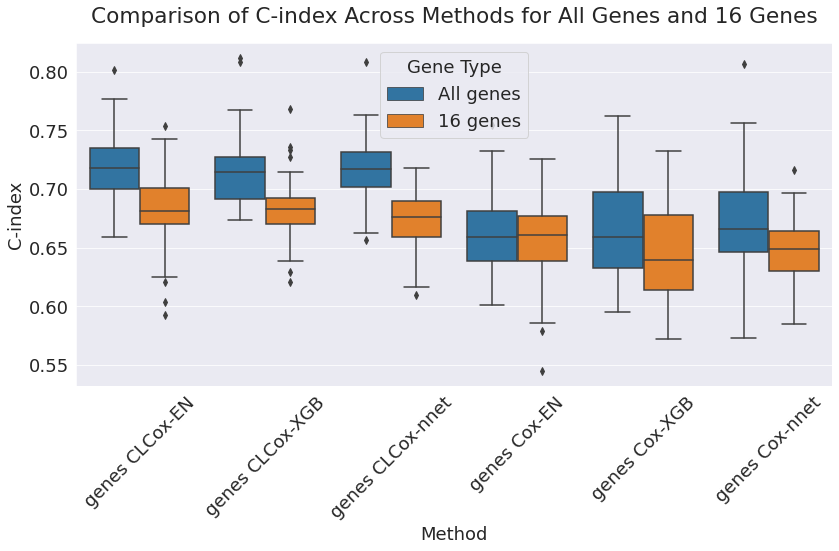

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from the Excel file
excel_path = 'Analysis_AffyOnco.xlsx'
affy_onco_data = pd.read_excel(excel_path)

# Rename columns based on the first row (method names) and then drop the first row
methods = affy_onco_data.iloc[0]
gene_types = ['All genes'] * 6 + ['16 genes'] * 6
new_columns = [f"{gene_type} {method}" for gene_type, method in zip(gene_types, methods)]
affy_onco_data.columns = new_columns
affy_onco_data = affy_onco_data.drop(index=0)

# Melt the DataFrame to long format for plotting
affy_onco_data_long = affy_onco_data.melt(var_name='Condition', value_name='C-index')

# Split the 'Condition' column into 'Gene Type' and 'Method'
affy_onco_data_long[['Gene Type', 'Method']] = affy_onco_data_long['Condition'].str.split(' ', 1, expand=True)
affy_onco_data_long['Gene Type'] = affy_onco_data_long['Gene Type'] + ' genes'
affy_onco_data_long['Method'] = affy_onco_data_long['Method'].str.strip()

# Convert 'C-index' to numeric
affy_onco_data_long['C-index'] = pd.to_numeric(affy_onco_data_long['C-index'])

# Plotting the boxplot comparison for "All genes" vs "16 genes" across the six methods
plt.figure(figsize=(12, 8))
sns.boxplot(x='Method', y='C-index', hue='Gene Type', data=affy_onco_data_long)
plt.title('Comparison of C-index Across Methods for All Genes and 16 Genes')
plt.xticks(rotation=45)
plt.xlabel('Method')
plt.ylabel('C-index')
plt.legend(title='Gene Type')
plt.tight_layout()
plt.show()